In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
pd.options.mode.chained_assignment = None

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from __future__ import division
import pprint
import pickle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import dateutil
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [4]:
df = pd.DataFrame(pickle.load(open('../data_files/cleaned_data_with_features.pkl', 'rb')))

In [7]:
df.head()

,_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,RESP,month,quarter,year,time_to_expire,amount_optional_support,optional_support,per_optional_support,school_previous_projects,teacher_previous_projects
0,7342bd01a2a7725ce033a179d22e382d,5c43ef5eac0f5857c266baa1ccfa3d3f,9e72d6f2f1e9367b578b6479aa5852b7,3.600097e+11,40.688454,-73.910432,Brooklyn,NY,11207,urban,...,1,9,3,2002,474 days,50.27,1,0.219520,0,0
1,b56b502d25666e29550d107bf7e17910,57426949b47700ccf62098e1e9b0220c,4a06a328dd87bd29892d73310052f45f,3.600077e+11,40.770233,-73.950760,New York,NY,10075,NaN,...,1,9,3,2002,471 days,27.44,1,0.219520,0,0
2,3a88a47f97bd0c9b7c6a745bcd831ce3,7a20087fac86232883537cab45c0a6c9,66d08b506d2f3c30dec9e6fdb03cc279,3.600122e+11,40.729763,-73.816925,Flushing,NY,11367,urban,...,1,9,3,2002,470 days,402.80,1,0.219510,0,0
3,0b8a4f8eb1822ab6dd5cd9ffb918ece3,e5d28482308e2007992ae8b358b31bce,9bc7d4d92193a453669b6e2a56128e87,3.600077e+11,40.701778,-74.011840,New York,NY,10004,urban,...,1,9,3,2002,470 days,247.83,1,0.219513,0,0
4,45235cb116b3b35cd86d1c3a63961d7d,214d75bd0e6ce3e7085278ddd8f26daa,f7f12dee0009e6f9afa301bcca9d5070,NaN,40.815018,-73.856094,Bronx,NY,10473,urban,...,1,9,3,2002,470 days,18.22,1,0.219518,0,0


In [8]:
y, X = dmatrices('RESP ~ school_previous_projects + teacher_previous_projects+ school_state+school_charter+school_magnet+ school_year_round+ school_nlns+ school_kipp+ school_charter_ready_promise+ teacher_prefix+teacher_teach_for_america+teacher_ny_teaching_fellow+primary_focus_subject+primary_focus_area+resource_type+poverty_level+grade_level+total_price_including_optional_support+students_reached+optional_support+quarter', data=df, return_type='dataframe')

y = np.ravel(y)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)

In [4]:
y, X = dmatrices(
    'RESP ~ primary_focus_area + primary_focus_subject + np.log(total_price_including_optional_support + np.sqrt(students_reached))',
    data=df, return_type='dataframe')
y = np.ravel(y)

std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

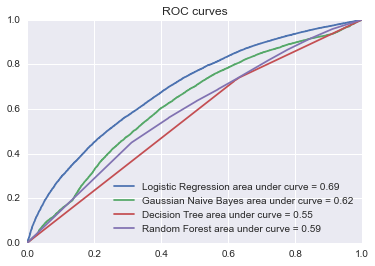

In [12]:
def curves(name, classifier):
    probas_ = classifier.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = "%s area under curve = %0.2f" 
             % (name, roc_auc_score(y_test, probas_[:, 1])))
    plt.legend(loc = "best")
    plt.title("ROC curves")
    
#curves("KNN", KNeighborsClassifier())
curves("Logistic Regression", LogisticRegression())
curves("Gaussian Naive Bayes", GaussianNB())
#curves("SVM Classifier", SVC(probability = True))
curves("Decision Tree", DecisionTreeClassifier())
curves("Random Forest", RandomForestClassifier())

In [ ]:
def test_model(name, main_model):
    model = main_model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print name, "test accuracy score:", accuracy_score(y_test, model.predict(x_test))
    
test_model("KNN", KNeighborsClassifier())
test_model("Logistic Regression", LogisticRegression())
test_model("Gaussian Naive Bayes", GaussianNB())
test_model("SVM Classifier", SVC())
test_model("Decision Tree", DecisionTreeClassifier())
test_model("Random Forest", RandomForestClassifier())

In [ ]:
names, accs = [], []
for algorithm in (LogisticRegression, 
                 KNeighborsClassifier, 
                 GaussianNB,
                 DecisionTreeClassifier, 
                 RandomForestClassifier):
    accuracy = np.mean(cross_val_score(algorithm(), X, y, cv = 2))
    print '%-30s %0.4f' % (algorithm.__name__, accuracy)
    names.append(algorithm.__name__)
    accs.append(accuracy)

In [1]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (25,10))
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
y, X = dmatrices('RESP ~ school_state+school_charter+school_magnet+ school_year_round+ school_nlns+ school_kipp+ school_charter_ready_promise+ teacher_prefix+teacher_teach_for_america+teacher_ny_teaching_fellow+primary_focus_subject+primary_focus_area+resource_type+poverty_level+grade_level+total_price_including_optional_support+students_reached+optional_support+quarter+teacher_previous_success+school_previous_success', data=df2, return_type='dataframe')

y = np.ravel(y)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7)

scale = preprocessing.MinMaxScaler().fit(X)
x_train = scale.transform(x_train)
x_test = scale.transform(x_test)

In [ ]:
def always_complete(x):
    return [1] * len(x)
y_pred = always_complete(X)

print "Baseline = %0.4f" % accuracy_score(y, y_pred) 

In [ ]:
model = LogisticRegression(penalty='l1', C=11)
model.fit(x_train, y_train)

In [ ]:
coefs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
coefs.sort([1])

In [ ]:
"""model = LogisticRegression()
model.fit(x_train, y_train)
accuracy = accuracy_score(y_test, model.predict(x_test))
print 'Logistic Regression (L2 penalty) accuracy: %.3f' % accuracy
"""
# L1 and L2 are just two different forms of regularization. The form of
# what is added to the cost funtion is slightly different. L2 is default,
# Let's try L1 here, too. Different problems work better with different
# penalty forms.
"""model = LogisticRegression(penalty='l1')
model.fit(x_train, y_train)
accuracy = accuracy_score(y_test, model.predict(x_test))
print 'Logistic Regression (L1 penalty) accuracy: %.3f' % accuracy"""

# Ok, let's also check different C values. C is just like alpha in Ridge Regression,
# It let's us fine tune how much regularization (how much shrinking) we will do on
# coeefficients. Default C is 1.0. Small C means more shrinking, tends to underfit,
# Large C means less shrinking, tends to overfit.
for C in np.linspace(0.05,100,10):
    model = LogisticRegression(penalty='l1', C=C)
    model.fit(x_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(x_test))
    print 'Logistic Regression (L1 penalty, C=%.2f) accuracy: %.3f' % (C,accuracy)

In [ ]:
coefs = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
coefs

In [ ]:
names, accs = [], []
for algorithm in (RandomForestClassifier,
                  DecisionTreeClassifier,
                  ExtraTreesClassifier,
                  LogisticRegression, 
                  GaussianNB,
                  KNeighborsClassifier, 
                  SVC):
    accuracy = np.mean(cross_val_score(algorithm(), X, y, cv = 10))
    print '%-30s %0.4f' % (algorithm.__name__, accuracy)
    names.append(algorithm.__name__)
    accs.append(accuracy)

In [ ]:
def test_model(name, main_model):
    model = main_model
    model.fit(x_train, y_train)
    precision = np.mean(cross_val_score(main_model, X, y.ravel(), scoring = 'precision'))
    recall = np.mean(cross_val_score(main_model, X, y.ravel(), scoring = 'recall'))
    f1 = np.mean(cross_val_score(main_model, X, y.ravel(), scoring = 'f1'))
    probas_ = main_model.fit(x_train, y_train).predict_proba(x_test)
    print name, "test accuracy score:", accuracy_score(y_test, model.predict(x_test))
    print name, "precision", precision
    print name, "recall", recall
    print name, "f1", f1
    print name, "confusion matrix", confusion_matrix(y_test, model.predict(x_test))